In [55]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

In [56]:
vectorizer = CountVectorizer(max_features=1000)

In [57]:
df_data = pd.read_csv('Data/cleaned_hotel_reviews.csv')
df_data.head()

,Review,Rating,label,clean_punc,lemmatized_review
0,nice hotel expensive parking got good deal sta...,4,positive,nice hotel expensive parking got good deal sta...,nice hotel expensive park get good deal stay h...
1,ok nothing special charge diamond member hilto...,2,negative,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,neutral,nice rooms not 4 experience hotel monaco seatt...,nice room not 4 experience hotel monaco seattl...
3,"unique, great stay, wonderful time hotel monac...",5,positive,unique great stay wonderful time hotel monaco ...,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,positive,great stay great stay went seahawk game awesom...,great stay great stay go seahawk game awesome ...


In [58]:
negative = df_data[df_data['label'] == 'negative']['lemmatized_review']
positive = df_data[df_data['label'] == 'positive']['lemmatized_review']
neutral = df_data[df_data['label'] == 'neutral']['lemmatized_review']

negative_matrix = vectorizer.fit_transform(negative)
positive_matrix = vectorizer.fit_transform(positive)
neutral_matrix = vectorizer.fit_transform(neutral)

negative_words = vectorizer.get_feature_names_out()
positive_words = vectorizer.get_feature_names_out()
neutral_words = vectorizer.get_feature_names_out()

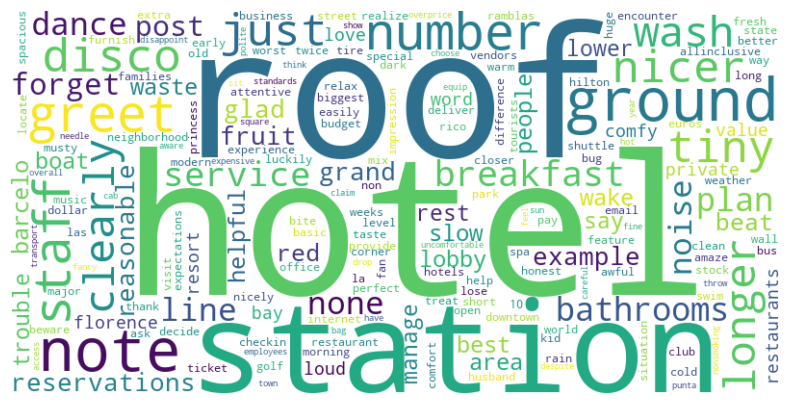

In [59]:
positive_dict = dict(zip(positive_words, positive_matrix.toarray().sum(axis=0)))
sorted_positive_dict = sorted(positive_dict.items(), key=lambda item: item[1], reverse=True)

plt.figure(figsize=(10, 5))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(positive_dict)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

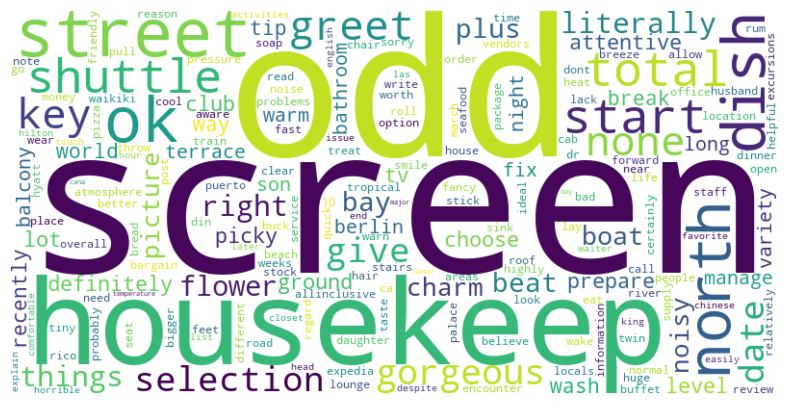

In [60]:
negative_dict = dict(zip(negative_words, negative_matrix.toarray().sum(axis=0)))
sorted_negative_dict = sorted(negative_dict.items(), key=lambda item: item[1], reverse=True)

plt.figure(figsize=(10, 5))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(negative_dict)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

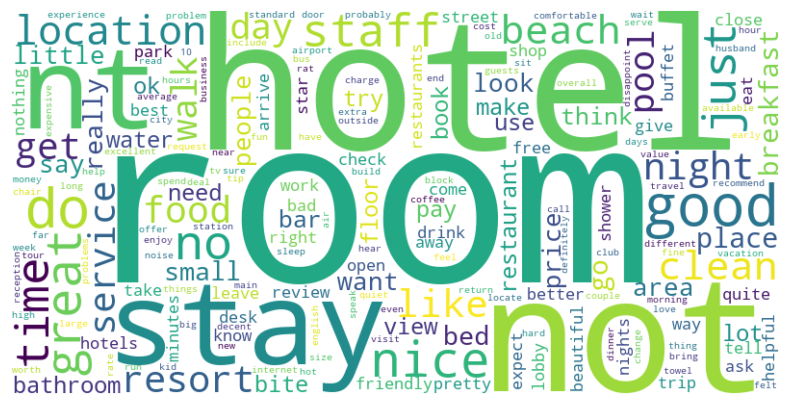

In [61]:
neutral_dict = dict(zip(neutral_words, neutral_matrix.toarray().sum(axis=0)))
sorted_neutral_dict = sorted(neutral_dict.items(), key=lambda item: item[1], reverse=True)

plt.figure(figsize=(10, 5))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(neutral_dict)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [62]:
label = ['positive', 'negative', 'neutral']

def encode_label(label):
    if label == 'positive':
        return 0
    elif label == 'negative':
        return 1
    else:
        return 2

In [63]:
df_data['label'] = df_data['label'].apply(encode_label)
df_data.head()

,Review,Rating,label,clean_punc,lemmatized_review
0,nice hotel expensive parking got good deal sta...,4,0,nice hotel expensive parking got good deal sta...,nice hotel expensive park get good deal stay h...
1,ok nothing special charge diamond member hilto...,2,1,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,2,nice rooms not 4 experience hotel monaco seatt...,nice room not 4 experience hotel monaco seattl...
3,"unique, great stay, wonderful time hotel monac...",5,0,unique great stay wonderful time hotel monaco ...,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,0,great stay great stay went seahawk game awesom...,great stay great stay go seahawk game awesome ...


In [64]:
x_train, x_test, y_train, y_test = train_test_split(df_data['lemmatized_review'], df_data['label'], test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((16392,), (4099,), (16392,), (4099,))

In [101]:
EMBEDDING_DIM = 15
MAXLEN = 32
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
MAX_EXAMPLES = 20000
NUM_LABELS = 3

In [102]:
tokenizer = Tokenizer(num_words=MAX_EXAMPLES, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_train_pad = pad_sequences(x_train_seq, maxlen=MAXLEN, truncating=TRUNCATING, padding=PADDING)
x_test_seq = tokenizer.texts_to_sequences(x_test)
x_test_pad = pad_sequences(x_test_seq, maxlen=MAXLEN, truncating=TRUNCATING, padding=PADDING)

In [112]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(MAX_EXAMPLES, EMBEDDING_DIM, input_length=MAXLEN),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(NUM_LABELS, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 20, 15)            300000    
                                                                 
 flatten_9 (Flatten)         (None, 300)               0         
                                                                 
 dense_27 (Dense)            (None, 4)                 1204      
                                                                 
 dense_28 (Dense)            (None, 3)                 15        
                                                                 
Total params: 301,219
Trainable params: 301,219
Non-trainable params: 0
_________________________________________________________________


In [113]:
history = model.fit(x_train_pad, y_train, epochs=5, validation_data=(x_test_pad, y_test))

Epoch 1/5
513/513 [==============================] - 3s 5ms/step - loss: 0.7145 - accuracy: 0.7468 - val_loss: 0.4774 - val_accuracy: 0.8285
Epoch 2/5
513/513 [==============================] - 3s 6ms/step - loss: 0.4251 - accuracy: 0.8402 - val_loss: 0.4370 - val_accuracy: 0.8343
Epoch 3/5
513/513 [==============================] - 2s 5ms/step - loss: 0.3307 - accuracy: 0.8692 - val_loss: 0.4457 - val_accuracy: 0.8312
Epoch 4/5
513/513 [==============================] - 3s 5ms/step - loss: 0.2320 - accuracy: 0.9177 - val_loss: 0.4804 - val_accuracy: 0.8292
Epoch 5/5
513/513 [==============================] - 3s 5ms/step - loss: 0.1423 - accuracy: 0.9605 - val_loss: 0.5509 - val_accuracy: 0.8190


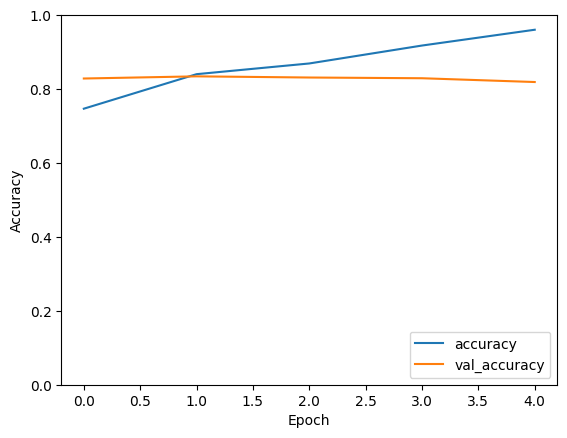

In [114]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [115]:
model.save('model.h5')